In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from utils import plot_3d_trajectory, plot_observations
from utils import solve_lorenz
from tqdm import tqdm
from utils import evaluate

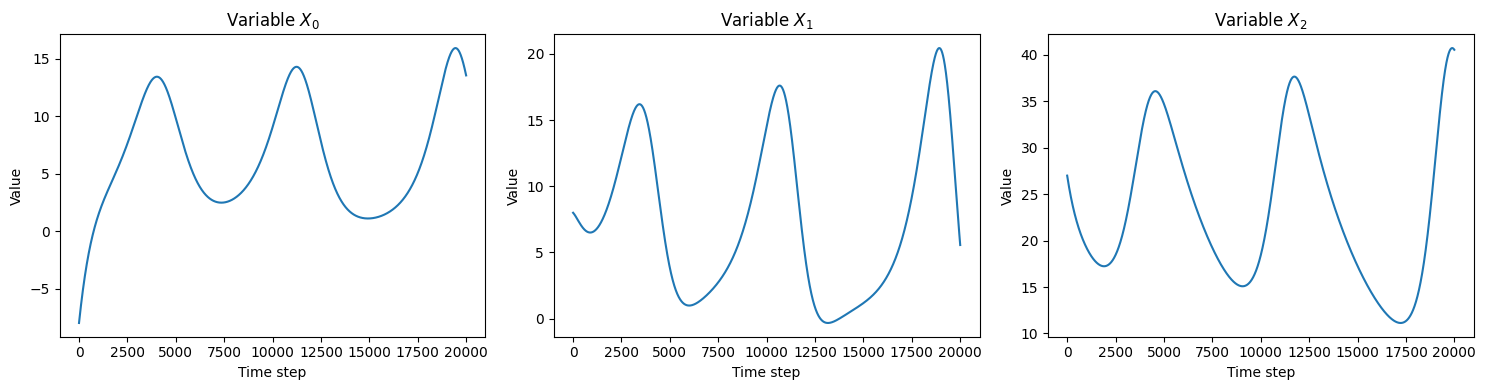

In [64]:
def f(X, theta):
    return np.array([theta[0]*X[1] - theta[0]*X[0],
                     theta[1]*X[0] - X[0]*X[2] - X[1],
                     X[0]*X[1] - theta[2]*X[2]])

def runge_kutta4(f, X_n, theta, h):
    k1 = f(X_n, theta)
    k2 = f(X_n + h*k1/2, theta)
    k3 = f(X_n + h*k2/2, theta)
    k4 = f(X_n + h*k3, theta)
    return X_n + h*(k1 + 2*k2 + 2*k3 + k4)/6

X_0 = np.array([-8.0, 8.0, 27.0], dtype=np.float64)
theta = np.array([10.0, 28.0, 8.0/3.0], dtype=np.float64)

t_0, t_f = 0, 2
h = 1e-4
N = int((t_f-t_0)/h)

observations = np.zeros((N, 3))
observations[0] = np.array(X_0)

for n in range(N-1):
    observations[n+1] = runge_kutta4(f, observations[n], theta, h)

observations_solver = solve_lorenz(t_0=t_0, t_f=t_f, dt=h, X_0=X_0)
plot_observations(observations)

In [ ]:
theta_estim = np.array([-7.0, 8.0, 27.0])
step_size = 0.01
estim_obs = np.zeros((N, 3))
A = np.array([[-1,1,0],
              [1,0,0],
              [0,0,-1]])

estim_obs[0:2] = observations[0:2]

def sgd_update(theta_estim, A, estim_obs, n): 
    X_n = estim_obs[n]
    dXdtheta = np.dot(estim_obs[:n], A).sum(axis = 0)
    grad = dXdtheta * (runge_kutta4(f, estim_obs[n-1], theta_estim, h)  - X_n)

    return grad

for n in tqdm(range(2,N-1)): 
    theta_estim = theta_estim - step_size * sgd_update(theta_estim, A, estim_obs, n)

  1%|▏         | 274/19997 [00:00<00:14, 1346.00it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

  2%|▏         | 409/19997 [00:00<00:17, 1112.33it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

  4%|▍         | 767/19997 [00:00<00:12, 1510.05it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

  6%|▌         | 1135/19997 [00:00<00:11, 1684.12it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

  8%|▊         | 1513/19997 [00:00<00:10, 1733.61it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

  9%|▉         | 1855/19997 [00:01<00:11, 1594.04it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 11%|█         | 2170/19997 [00:01<00:12, 1468.42it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 12%|█▏        | 2318/19997 [00:01<00:12, 1392.80it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 13%|█▎        | 2588/19997 [00:01<00:14, 1172.32it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 14%|█▎        | 2708/19997 [00:02<00:18, 921.50it/s] 

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 15%|█▍        | 2914/19997 [00:02<00:17, 960.12it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 16%|█▌        | 3122/19997 [00:02<00:17, 962.68it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 17%|█▋        | 3366/19997 [00:02<00:15, 1091.97it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 18%|█▊        | 3598/19997 [00:02<00:16, 1024.65it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 19%|█▊        | 3704/19997 [00:03<00:17, 942.47it/s] 

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 19%|█▉        | 3896/19997 [00:03<00:17, 919.84it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 21%|██        | 4102/19997 [00:03<00:18, 854.90it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 21%|██        | 4191/19997 [00:03<00:23, 679.96it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 21%|██▏       | 4266/19997 [00:03<00:25, 613.36it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 22%|██▏       | 4392/19997 [00:04<00:29, 524.14it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 23%|██▎       | 4522/19997 [00:04<00:27, 570.58it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 23%|██▎       | 4675/19997 [00:04<00:23, 657.16it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 24%|██▍       | 4831/19997 [00:04<00:21, 718.76it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 25%|██▍       | 4998/19997 [00:04<00:19, 773.67it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 26%|██▌       | 5155/19997 [00:05<00:19, 764.04it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 26%|██▌       | 5236/19997 [00:05<00:19, 776.15it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 27%|██▋       | 5382/19997 [00:05<00:24, 606.34it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 28%|██▊       | 5508/19997 [00:05<00:25, 578.71it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 28%|██▊       | 5568/19997 [00:05<00:27, 515.80it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 28%|██▊       | 5679/19997 [00:06<00:27, 526.31it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 29%|██▉       | 5791/19997 [00:06<00:26, 536.05it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 30%|██▉       | 5908/19997 [00:06<00:26, 523.04it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 30%|███       | 6029/19997 [00:06<00:26, 534.73it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 31%|███       | 6165/19997 [00:06<00:22, 602.57it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 32%|███▏      | 6311/19997 [00:07<00:21, 651.20it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 32%|███▏      | 6446/19997 [00:07<00:20, 646.36it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 33%|███▎      | 6525/19997 [00:07<00:19, 686.94it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 33%|███▎      | 6594/19997 [00:07<00:26, 500.55it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 34%|███▎      | 6700/19997 [00:08<00:34, 386.83it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 34%|███▍      | 6811/19997 [00:08<00:28, 456.42it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 35%|███▍      | 6959/19997 [00:08<00:22, 585.19it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 35%|███▌      | 7098/19997 [00:08<00:20, 639.24it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 36%|███▌      | 7245/19997 [00:08<00:18, 689.61it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 37%|███▋      | 7386/19997 [00:09<00:18, 689.71it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 38%|███▊      | 7541/19997 [00:09<00:17, 731.25it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 38%|███▊      | 7695/19997 [00:09<00:16, 749.21it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 39%|███▉      | 7854/19997 [00:09<00:15, 768.87it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 40%|████      | 8008/19997 [00:09<00:15, 764.09it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 40%|████      | 8085/19997 [00:10<00:16, 741.38it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 41%|████      | 8160/19997 [00:10<00:19, 602.32it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 41%|████▏     | 8280/19997 [00:10<00:24, 481.34it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 42%|████▏     | 8383/19997 [00:10<00:25, 461.05it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 43%|████▎     | 8512/19997 [00:10<00:21, 546.28it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 43%|████▎     | 8650/19997 [00:11<00:18, 612.61it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 44%|████▍     | 8774/19997 [00:11<00:18, 598.46it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 44%|████▍     | 8898/19997 [00:11<00:18, 585.08it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 45%|████▌     | 9017/19997 [00:11<00:19, 571.91it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 46%|████▌     | 9145/19997 [00:12<00:17, 605.93it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 46%|████▋     | 9273/19997 [00:12<00:17, 617.73it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 47%|████▋     | 9401/19997 [00:12<00:16, 625.29it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 47%|████▋     | 9464/19997 [00:12<00:17, 605.96it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 48%|████▊     | 9584/19997 [00:12<00:21, 478.37it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 48%|████▊     | 9636/19997 [00:12<00:22, 459.86it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 49%|████▊     | 9729/19997 [00:13<00:25, 404.42it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 49%|████▉     | 9847/19997 [00:13<00:21, 482.37it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 50%|████▉     | 9957/19997 [00:13<00:19, 503.84it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 50%|█████     | 10067/19997 [00:13<00:19, 511.06it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 51%|█████     | 10170/19997 [00:14<00:19, 496.97it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 51%|█████     | 10221/19997 [00:14<00:23, 417.37it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 51%|█████▏    | 10266/19997 [00:14<00:27, 348.18it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 52%|█████▏    | 10343/19997 [00:14<00:27, 349.96it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 52%|█████▏    | 10420/19997 [00:14<00:26, 360.12it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 53%|█████▎    | 10499/19997 [00:15<00:27, 345.25it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 53%|█████▎    | 10593/19997 [00:15<00:23, 408.71it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 54%|█████▎    | 10704/19997 [00:15<00:19, 473.74it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 54%|█████▍    | 10821/19997 [00:15<00:19, 479.26it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 55%|█████▍    | 10930/19997 [00:15<00:18, 493.07it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 55%|█████▌    | 11038/19997 [00:16<00:17, 502.10it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 56%|█████▌    | 11139/19997 [00:16<00:18, 468.03it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 56%|█████▌    | 11187/19997 [00:16<00:21, 401.07it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 56%|█████▋    | 11275/19997 [00:16<00:20, 415.75it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 57%|█████▋    | 11384/19997 [00:16<00:18, 471.57it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 57%|█████▋    | 11480/19997 [00:17<00:18, 452.49it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 58%|█████▊    | 11583/19997 [00:17<00:17, 470.41it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 58%|█████▊    | 11631/19997 [00:17<00:18, 451.10it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 59%|█████▊    | 11718/19997 [00:17<00:23, 357.54it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 59%|█████▉    | 11800/19997 [00:18<00:22, 366.04it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 59%|█████▉    | 11882/19997 [00:18<00:21, 375.70it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 60%|█████▉    | 11959/19997 [00:18<00:23, 347.61it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 60%|██████    | 12053/19997 [00:18<00:19, 405.48it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 60%|██████    | 12095/19997 [00:18<00:20, 380.87it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 61%|██████    | 12169/19997 [00:19<00:25, 307.77it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 61%|██████    | 12244/19997 [00:19<00:23, 335.43it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 62%|██████▏   | 12327/19997 [00:19<00:20, 371.43it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 62%|██████▏   | 12411/19997 [00:19<00:19, 395.71it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 62%|██████▏   | 12452/19997 [00:19<00:19, 380.20it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 63%|██████▎   | 12527/19997 [00:20<00:25, 292.95it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 63%|██████▎   | 12559/19997 [00:20<00:28, 263.58it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 63%|██████▎   | 12632/19997 [00:20<00:24, 301.44it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 64%|██████▎   | 12704/19997 [00:20<00:22, 318.05it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 64%|██████▍   | 12791/19997 [00:20<00:19, 374.40it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 64%|██████▍   | 12877/19997 [00:21<00:17, 398.66it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 65%|██████▍   | 12957/19997 [00:21<00:18, 377.29it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 65%|██████▌   | 13035/19997 [00:21<00:19, 353.77it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 65%|██████▌   | 13072/19997 [00:21<00:21, 326.32it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 66%|██████▌   | 13138/19997 [00:21<00:23, 292.16it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 66%|██████▌   | 13210/19997 [00:22<00:20, 325.31it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 66%|██████▋   | 13282/19997 [00:22<00:20, 326.59it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 67%|██████▋   | 13363/19997 [00:22<00:18, 362.91it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 67%|██████▋   | 13441/19997 [00:22<00:17, 375.49it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 68%|██████▊   | 13521/19997 [00:23<00:17, 378.51it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 68%|██████▊   | 13603/19997 [00:23<00:16, 391.06it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 68%|██████▊   | 13691/19997 [00:23<00:15, 410.25it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 69%|██████▉   | 13774/19997 [00:23<00:15, 395.67it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 69%|██████▉   | 13862/19997 [00:23<00:14, 414.67it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 70%|██████▉   | 13949/19997 [00:24<00:14, 403.30it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 70%|██████▉   | 13990/19997 [00:24<00:15, 377.74it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 70%|███████   | 14064/19997 [00:24<00:19, 305.62it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 71%|███████   | 14128/19997 [00:24<00:19, 305.02it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 71%|███████   | 14195/19997 [00:24<00:18, 312.81it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 71%|███████▏  | 14272/19997 [00:25<00:16, 346.83it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 72%|███████▏  | 14351/19997 [00:25<00:15, 367.35it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 72%|███████▏  | 14439/19997 [00:25<00:13, 400.37it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 73%|███████▎  | 14525/19997 [00:25<00:13, 400.74it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

 73%|███████▎  | 14638/19997 [00:25<00:09, 563.37it/s]

[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -15.9840088  -53.98640885]
[ 31.98240425 -1

KeyboardInterrupt: 

In [104]:
theta_estim = np.array([-7.0, 8.0, 27.0])
step_size = 1e-3
A = np.array([[-1, 1, 0],
              [1, 0, 0],
              [0, 0, -1]])

estim_obs = observations.copy()

def sgd_update(theta_estim, A, estim_obs, n):
    sum_term = np.dot(estim_obs[:n], A).sum(axis=0)   

    X_nm1 = estim_obs[n-1]                 
    error = runge_kutta4(f, X_nm1, theta_estim, h) - estim_obs[n]     

    grad = sum_term * error
    return grad

for n in tqdm(range(1, N)):
    theta_estim = theta_estim - step_size * sgd_update(theta_estim, A, estim_obs, n)

100%|██████████| 19999/19999 [00:21<00:00, 950.25it/s]


array([1.62656153e-07, 1.94497117e-11, 3.35143580e-11])